In [13]:
from typing import TypedDict
import numpy as np
import numpy.typing as npt
from sklearn.linear_model import LogisticRegression as LR
from munch import Munch

from oneml.processors import Task, CombinedPipeline, display_dag

In [2]:
StandardizeTrainOutput = TypedDict(
    "StandardizeTrainOutput", {"mean": float, "scale": float}
)


class StandardizeTrain:
    def process(self, X: npt.NDArray[np.float64]) -> StandardizeTrainOutput:
        mean = X.mean()
        scale = X.std()
        return StandardizeTrainOutput({"mean": mean, "scale": scale})


StandardizeEvalOutput = TypedDict("StandardizeEvalOutput", {"Z": npt.NDArray[np.float64]})


class StandardizeEval:
    def __init__(self, mean: float, scale: float) -> None:
        self._mu = mean
        self._scale = scale

    def process(self, X: npt.NDArray[np.float64]) -> StandardizeEvalOutput:
        Z = (X-self.mean)/self.scale
        return StandardizeEvalOutput({"Z": Z})


In [3]:
from sklearn.linear_model import LogisticRegression as LR

LRTrainOutput = TypedDict("LRTrainOutput", {"model": LR})

class LRTrain:
    def process(self, X: npt.NDArray[np.float64], Y: npt.NDArray[np.bool8]) -> LRTrainOutput:
        lr = LR()
        lr.fit(X=X, y=Y)
        return LRTrainOutput(model=lr)

LREvalOutput = TypedDict("LREvalOutput", {"predictions": npt.NDArray[np.float64]})
    
class LREval:
    def __init__(self, model: LR) -> None:
        self._model = model

    def process(self, X: npt.ArrayLike) -> LREvalOutput:
        return LREvalOutput(predictions=self._model.predict(X=X))

In [14]:
std_train = Task(StandardizeTrain)
std_eval = Task(StandardizeEval)
lr_train = Task(LRTrain)
lr_eval = Task(LREval)

In [16]:
std_eval_eval = CombinedPipeline(std_eval, name="eval")
std_eval_train = CombinedPipeline(std_eval, name="train")

std = CombinedPipeline(
    std_train, std_eval_eval, std_eval_train,
    name="std",
    inputs={
        "train_X": std_train.inputs.X | std_eval_train.inputs.X,
        "eval_X": std_eval_eval.inputs.X,
    },
    dependencies=(
        std_train.outputs >> std_eval_eval.inputs,
        std_train.outputs >> std_eval_train.inputs,
    ),
    outputs={
        "train_Z": std_eval_train.outputs.Z,
        "eval_Z": std_eval_eval.outputs.Z,
    }
)

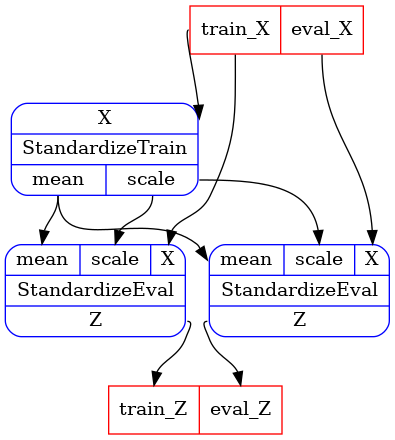

In [17]:
display_dag(std)

In [18]:
lr_eval_eval = CombinedPipeline(lr_eval, name="eval")
lr_eval_train = CombinedPipeline(lr_eval, name="train")

lr = CombinedPipeline(
    lr_train, lr_eval_eval, lr_eval_train,
    name="lr",
    inputs={
        "train_X": lr_train.inputs.X | lr_eval_train.inputs.X,
        "eval_X": lr_eval_eval.inputs.X,
        "train_Y": lr_train.inputs.Y,
    },
    dependencies=(
        lr_train.outputs >> lr_eval_eval.inputs,
        lr_train.outputs >> lr_eval_train.inputs,
    ),
    outputs={
        "train_predictions": lr_eval_train.outputs.predictions,
        "eval_preditcions": lr_eval_eval.outputs.predictions,
    }
)

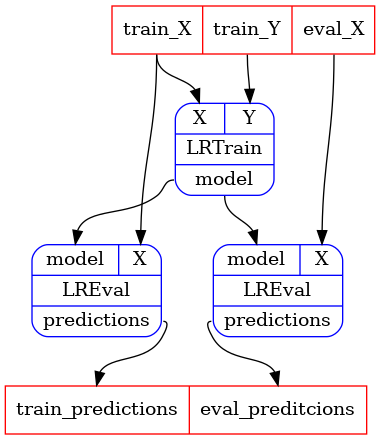

In [19]:
display_dag(lr)

In [20]:
std_lr = CombinedPipeline(
    std, lr,
    name="std_lr",
    dependencies=(
        std.outputs.train_Z >> lr.inputs.train_X,
        std.outputs.eval_Z >> lr.inputs.eval_X,
    )
)

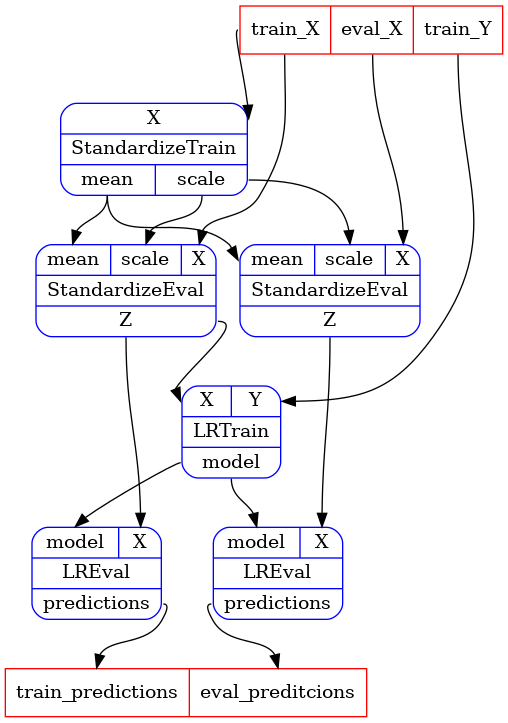

In [10]:
display_dag(std_lr)

In [11]:
def std(train_X, eval_X):
    std_params = std_train(train_X)
    train_Z = std_eval(train_Z, **std_params)
    eval_Z = std_eval(eval_Z, **std_params)
    return Munch(train_Z=train_X, eval_Z=eval_Z)

def lr(train_X, train_Y, eval_features):
    lr_params = lr_train(train_X, train_Y)
    train_predictions = lr_eval(train_X, **lr_params)
    eval_predictions = lr_eval(eval_features, **lr_params)
    return Munch(train_predictions=train_predictions, eval_predictions=eval_predictions)

def std_lr(train_X, train_Y, eval_X):
    std_res = std(train_X, eval_X)
    res = lr(
        train_X=std_res.train_Z,
        train_Y=train_Y,
        eval_X=std_res.eval_Z)
    return res

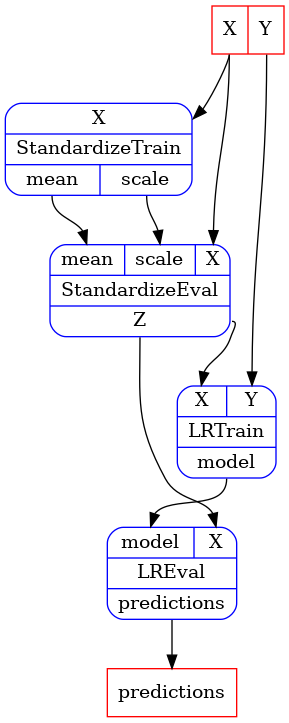

In [22]:
display_dag(
    CombinedPipeline(
        std_train, std_eval, lr_train, lr_eval,
        name="std_lr",
        dependencies=(
            std_train.outputs >> std_eval.inputs,
            std_eval.outputs.Z >> lr_train.inputs.X,
            std_eval.outputs.Z >> lr_eval.inputs.X,
            lr_train.outputs >> lr_eval.inputs,
        ),
    )
)